<a href="https://colab.research.google.com/github/LucasCalbucuraZ/MOS/blob/main/tesis/MOS_3km_Tmin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# MODEL OUTPUT STATISTICS (MOS) 
# Calibración de las series de tiempo históricas (construidas considerando las primeras 24 horas de pronóstico de cada día)

# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib import style
import seaborn as sns
import datetime
from datetime import datetime, timedelta

# Utilidades
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Cargamos los 704 datos diarios desde GitHub
# T2_max, T2_WRF_max, T2_min, T2_WRF_min, P_WRF_max, P_WRF_min, U10_WRF_max, U10_WRF_min, V10_WRF_max, V10_WRF_min
# ==============================================================================
CUCAO = pd.read_csv('https://raw.githubusercontent.com/LucasCalbucuraZ/MOS/main/data/CUCAO_diario_abs.csv'); 
MELINKA = pd.read_csv('https://raw.githubusercontent.com/LucasCalbucuraZ/MOS/main/data/MELINKA_diario_abs.csv'); 

# Se genera el vector fecha (desde el 1 de septiembre del 2020 al 5 de agosto de 2022)
# ==============================================================================
t = np.arange(np.datetime64('2020-09-01'), np.datetime64('2022-08-01'))
time= pd.to_datetime(t)

# Interpolamos los NaN para poder construir la regresión lineal múltiple  
# ==============================================================================
# CUCAO 
T2_WRF_Min=CUCAO["T2_WRF_min"].interpolate(method='polynomial',order=2); CUCAO["T2_WRF_min"]=T2_WRF_Min.to_frame()
P_WRF_Min= CUCAO["P_WRF_min"].interpolate(method='polynomial', order=2);  CUCAO["P_WRF_min"]=P_WRF_Min.to_frame()
U10_WRF_Min= CUCAO["U10_WRF_min"].interpolate(method='polynomial', order=2);  CUCAO["U10_WRF_min"]=U10_WRF_Min.to_frame()
V10_WRF_Min= CUCAO["V10_WRF_min"].interpolate(method='polynomial', order=2); CUCAO["V10_WRF_min"]=V10_WRF_Min.to_frame()
del T2_WRF_Min; del P_WRF_Min; del U10_WRF_Min; del V10_WRF_Min; 
# ==============================================================================
# MELINKA 
T2_WRF_Min = MELINKA["T2_WRF_min"].interpolate(method='polynomial',order=2); MELINKA["T2_WRF_min"]=T2_WRF_Min.to_frame()
P_WRF_Min  = MELINKA["P_WRF_min"].interpolate(method='polynomial', order=2);  MELINKA["P_WRF_min"]=P_WRF_Min.to_frame()
U10_WRF_Min= MELINKA["U10_WRF_min"].interpolate(method='polynomial', order=2); MELINKA["U10_WRF_min"]=U10_WRF_Min.to_frame()
V10_WRF_Min= MELINKA["V10_WRF_min"].interpolate(method='polynomial', order=2); MELINKA["V10_WRF_min"]=V10_WRF_Min.to_frame()
del T2_WRF_Min; del P_WRF_Min; del U10_WRF_Min; del V10_WRF_Min;

In [20]:
# División de los datos en train y test
ESTACION =  CUCAO
predictores = ESTACION.filter(['T2_WRF_min','P_WRF_min','U10_WRF_min','V10_WRF_min'], axis=1)
predictores.columns=['T2','P','U10','V10']

sc=StandardScaler()
predictores_std = sc.fit_transform(predictores)
predictors = pd.DataFrame(predictores_std, columns = ['T2','P','U10','V10'])


y = ESTACION['T2_min'] # Variable dependiente (en este caso son las observaciones, recordar que es un problema inverso)

# Acá dividimos los datos conservando el primer 90% para entrenar el modelo derivando los coeficientes de regresión y luego
# los aplicamos en el 10% no utilizado. Lo anterior también se conoce como validación cruzada (o cross-validation) y es la
# mejor forma de cuantificar la precisión o skill de MOS (o de cualquier predicción estadística..)
X_train, X_test, y_train, y_test = train_test_split(
                                        predictors,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.994,       # 90%-10% 
                                        shuffle      = False      # División lineal ya que los datos tienen un orden temporal
                                    )

# Creación del modelo utilizando matrices como en scikitlearn
# ==============================================================================
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit() #Entrena el algoritmo
print(modelo.summary())

# CUCAO :   0.852, 0.853, 0.853, 0.853

# MELINKA : 0.870 , 0.887, 0.889, 0.890

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     1004.
Date:                Wed, 12 Apr 2023   Prob (F-statistic):          7.76e-287
Time:                        01:20:38   Log-Likelihood:                -1126.7
No. Observations:                 699   AIC:                             2263.
Df Residuals:                     694   BIC:                             2286.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3897      0.046    182.234      0.0

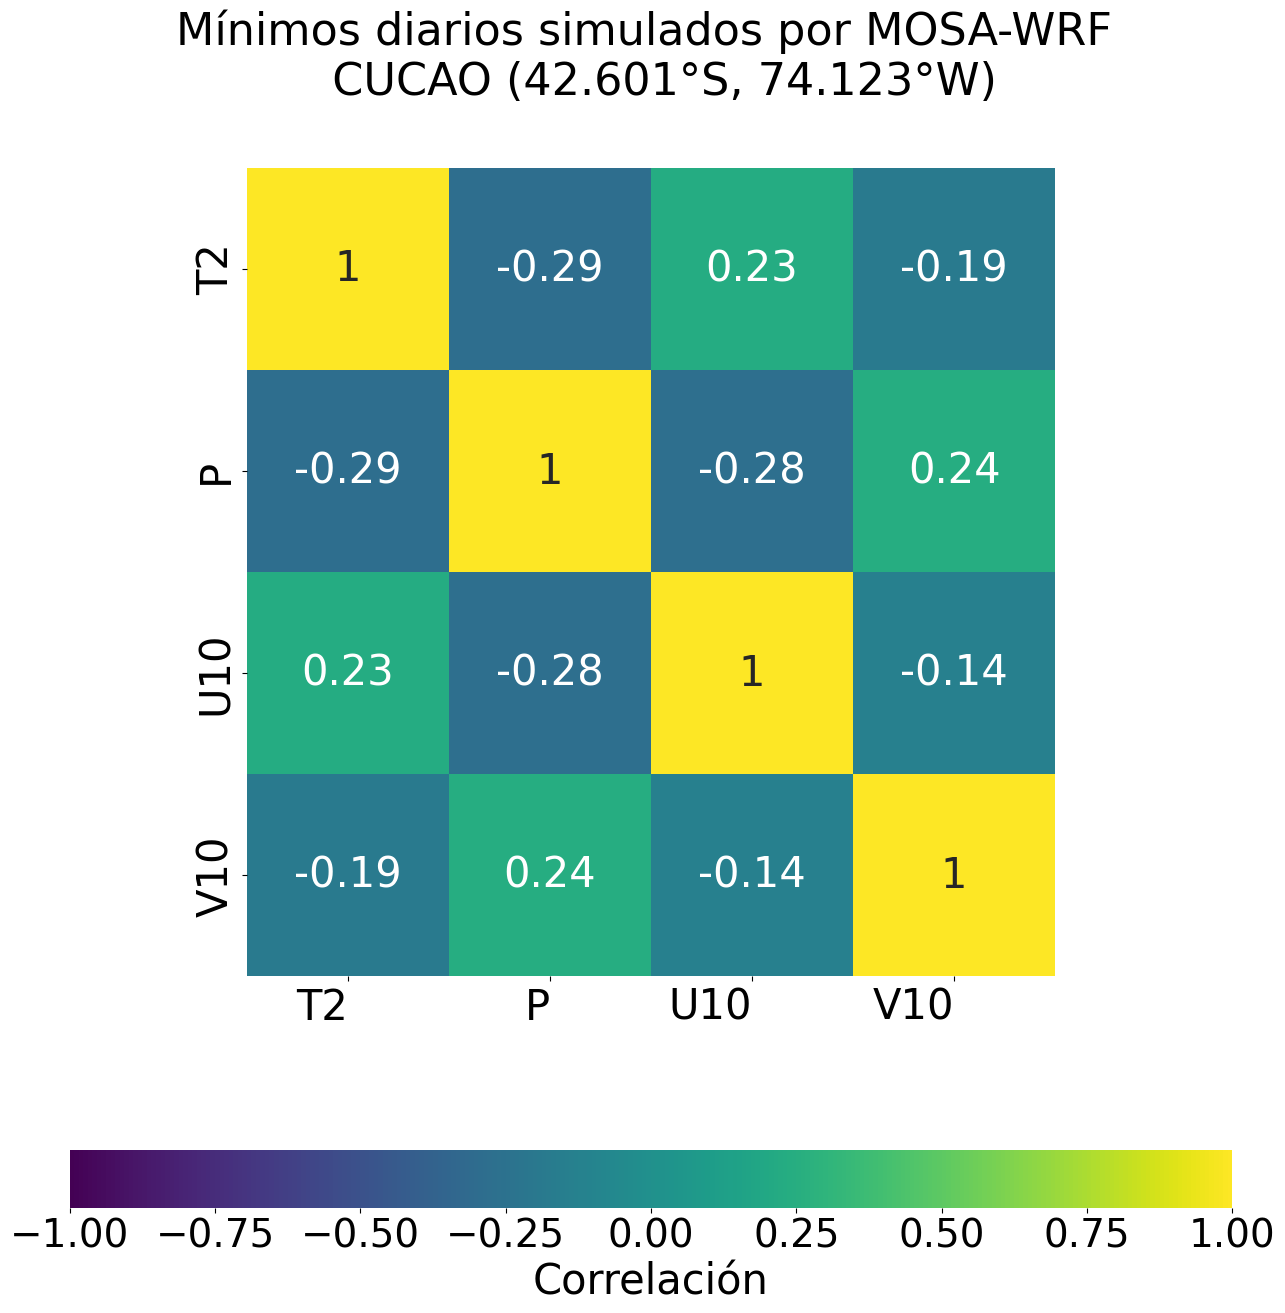

In [21]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para generar la matriz de correlación
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)

    return(corr_mat)

corr_matrix = predictores.select_dtypes(include=['float64', 'int']).corr(method='pearson')

# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
plt.title('Mínimos diarios simulados por MOSA-WRF \n  CUCAO (42.601°S, 74.123°W)',fontsize=32,y=1.08)
sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = True,
    cbar_kws = dict(use_gridspec=False,location="bottom"),
    annot_kws = {"size": 30},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.color_palette("viridis", as_cmap=True),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 0,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 30)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=28)
ax.collections[0].colorbar.set_label("Correlación",fontsize=30)
plt.savefig('CUCAO_heatmap_min2.png')

In [7]:
# AJUSTANDO LA SERIE DE TIEMPO HISTÓRICA DE CUCAO CON INTERVALO DE CONFIANZA AL 95%
# ==============================================================================
predicciones_xtrain1 = modelo.predict(exog = X_train)
#predicciones_xtrain.isnull().sum().sum() #para revisar los NaN

In [8]:
reconstruccion_CUCAO=predicciones_xtrain1
OBS_CUCAO =y_train.flatten()
MOS_CUCAO = reconstruccion_CUCAO
residuos_CUCAO=MOS_CUCAO-OBS_CUCAO
WRF_CUCAO=CUCAO["T2_WRF_min"].iloc[0:699]

In [10]:
# AJUSTANDO LA SERIE DE TIEMPO HISTÓRICA DE MELINKA CON INTERVALO DE CONFIANZA AL 95%
# ==============================================================================
predicciones_xtrain2 = modelo.predict(exog = X_train)
#predicciones_xtrain.isnull().sum().sum() #para revisar los NaN

In [11]:
reconstruccion_MELINKA=predicciones_xtrain2
OBS_MELINKA =y_train.flatten()
MOS_MELINKA = reconstruccion_MELINKA
residuos_MELINKA=MOS_MELINKA-OBS_MELINKA
WRF_MELINKA=MELINKA["T2_WRF_min"].iloc[0:699]

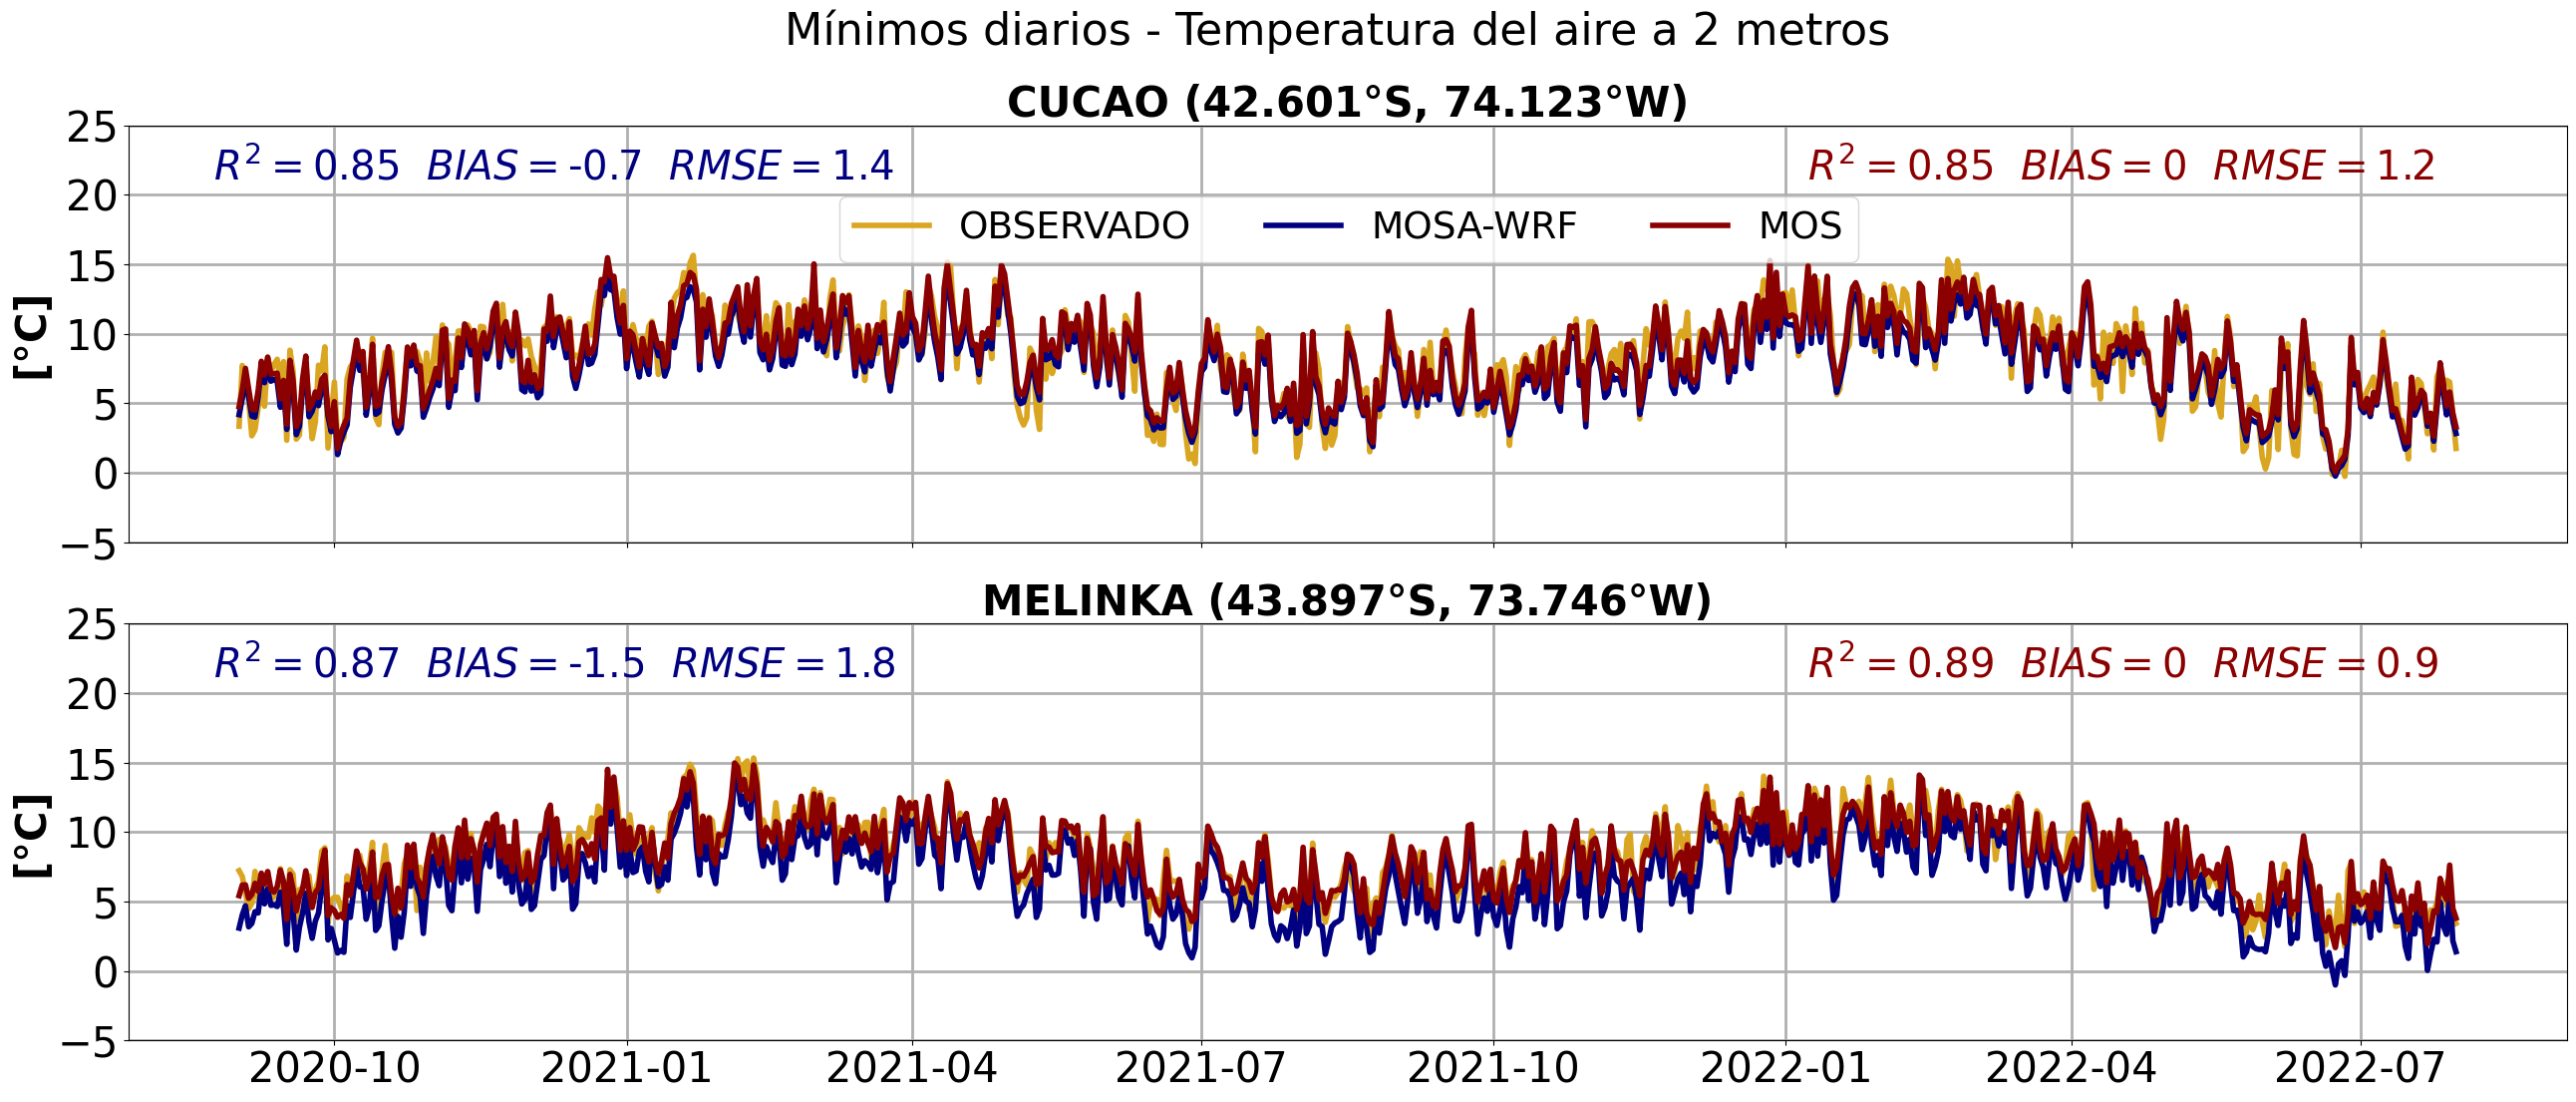

In [13]:
# SERIES DE TIEMPO PARA LOS MINIMOS DIARIOS
# ======================================================================================
fig, ax = plt.subplots(2,figsize=(26,11), sharex=True)
fig.suptitle('Mínimos diarios - Temperatura del aire a 2 metros',x=0.518,y=1.0,fontsize=32)
loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
# CUCAO
ax[0].plot(time,OBS_CUCAO,color='goldenrod',linewidth=4,label='OBSERVADO') #Observado
ax[0].plot(time,WRF_CUCAO,color='navy',linewidth=4,label='MOSA-WRF') #Simulado 
ax[0].plot(time,MOS_CUCAO,color='darkred',linewidth=4,label='MOS') #Diferencia
ax[0].legend(fontsize=27,ncol=3,bbox_to_anchor=(0.284, 0.628))
ax[0].set_ylabel('[°C]', fontsize = 30, weight='bold')
ax[0].set_ylim(-5,25)
ax[0].yaxis.set_major_locator(loc)
ax[0].set_title('CUCAO (42.601°S, 74.123°W)',fontsize=30,x=0.5, y=1, weight='bold')
ax[0].grid(True,linewidth=2)
ax[0].annotate("$R^2=0.85$  $BIAS=0$  $RMSE=1.2$", xy=(0.6885, 0.87), xycoords=ax[0].transAxes,fontsize=29,color='darkred')
ax[0].annotate("$R^2=0.85$  $BIAS=$-$0.7$  $RMSE=1.4$",  xy=(0.035, 0.87), xycoords=ax[0].transAxes,fontsize=29,color='navy')


# MELINKA
ax[1].plot(time,OBS_MELINKA,color='goldenrod',linewidth=4) #Observado
ax[1].plot(time,WRF_MELINKA,color='navy',linewidth=4) #Simulado 
ax[1].plot(time,MOS_MELINKA,color='darkred',linewidth=4) #Diferencia
#ax[2].set_xlabel('Fecha', fontsize = 30, weight='bold')
ax[1].set_ylabel('[°C]', fontsize = 30, weight='bold')
ax[1].set_ylim(-5,25)
ax[1].yaxis.set_major_locator(loc)
ax[1].set_title('MELINKA (43.897°S, 73.746°W)',fontsize=30,x=0.5, y=1, weight='bold')
ax[1].grid(True,linewidth=2)
ax[1].annotate("$R^2=0.89$  $BIAS=0$  $RMSE=0.9$", xy=(0.6885, 0.87), xycoords=ax[1].transAxes,fontsize=29,color='darkred')
ax[1].annotate("$R^2=0.87$  $BIAS=$-$1.5$  $RMSE=1.8$", xy=(0.035 , 0.87), xycoords=ax[1].transAxes,fontsize=29,color='navy')


fig.tight_layout()
plt.savefig("T2_min_MOS.png")

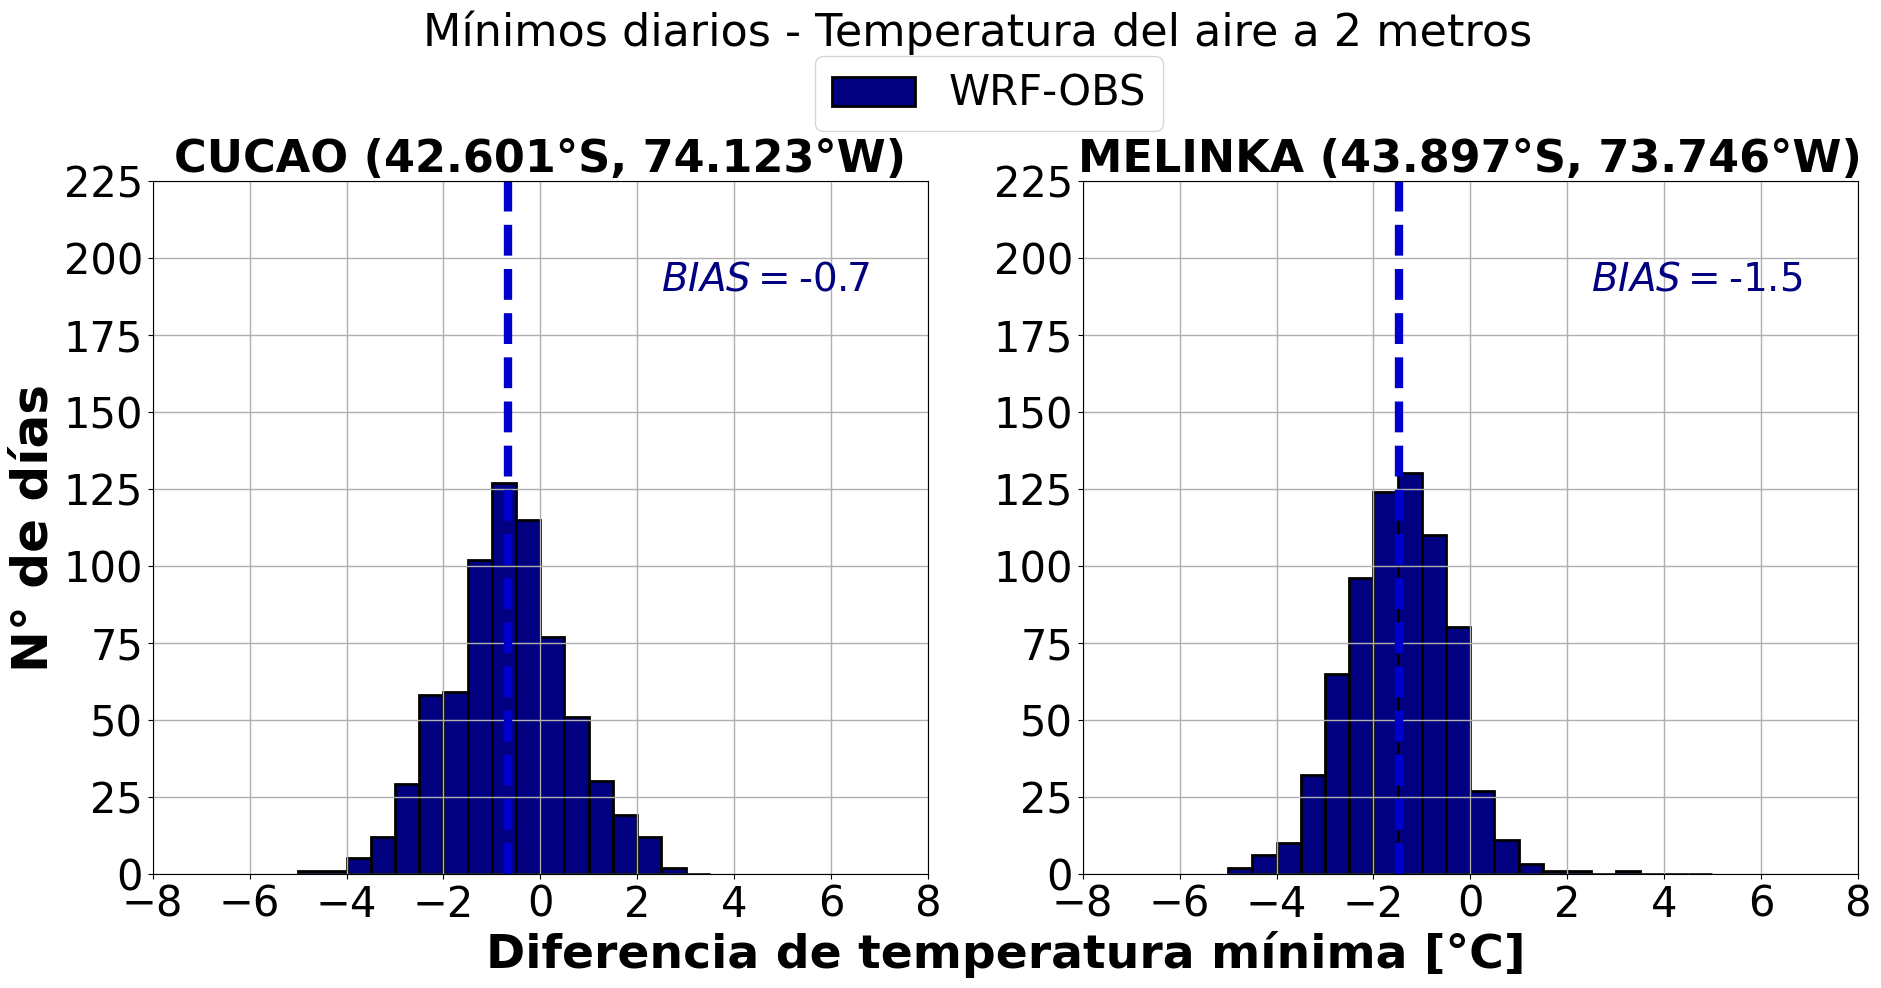

In [14]:
# HISTOGRAMA DE LAS DIFERENCIAS
intervalos = [-8, -6, -4, -2, 0, 2, 4, 6, 8] #indicamos los extremos de los intervalos
intervalos_y = [0, 25, 50, 75, 100, 125, 150, 175, 200,225] #indicamos los extremos de los intervalos

# ======================================================================================  
fig, ax = plt.subplots(1,2,figsize=(22,9),sharey=False)
plt.subplot(1,2,1) # DIFERENCIA TEMPERATURA MÁXIMA
fig.suptitle('Mínimos diarios - Temperatura del aire a 2 metros',x=0.5,y=1.07,fontsize=32)
plt.hist(WRF_CUCAO-OBS_CUCAO, bins=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5],color = "navy",edgecolor='k',alpha=1,linewidth=2,label='WRF-OBS')
plt.axvline((WRF_CUCAO-OBS_CUCAO).mean(), color='mediumblue', linestyle='dashed', linewidth=6)
plt.ylabel('N° de días', fontsize=36, weight='bold')
plt.title('CUCAO (42.601°S, 74.123°W)',fontsize=32,weight='bold')
plt.ylim(0,225); plt.xlim(-8,8) ; plt.legend(bbox_to_anchor=(1.33, 1.21),fontsize=30,ncol=2)
plt.xticks(intervalos,fontsize=30);  plt.yticks(fontsize=30);  plt.grid(True,linewidth=1)
plt.yticks(intervalos_y); 
plt.text(2.5, 189.3, r'$BIAS=$-$0.7$',fontsize=28,color='navy')

plt.subplot(1,2,2) # DIFERENCIA TEMPERATURA MÁXIMA
plt.hist(WRF_MELINKA-OBS_MELINKA, bins=[-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5],color = "navy",edgecolor='k',alpha=1,linewidth=2,label='WRF-OBS')
plt.axvline((WRF_MELINKA-OBS_MELINKA).mean(), color='mediumblue', linestyle='dashed', linewidth=6)
plt.title('MELINKA (43.897°S, 73.746°W)',fontsize=32,weight='bold')
plt.xlabel('Diferencia de temperatura mínima [°C]', fontsize=34, weight='bold', horizontalalignment='center', x=-0.1)
plt.ylim(0,225); plt.xlim(-8,8) ;
plt.xticks(intervalos,fontsize=30);  plt.yticks(fontsize=30);  plt.grid(True,linewidth=1)
plt.yticks(intervalos_y);
plt.text(2.5, 189.3, r'$BIAS=$-$1.5$',fontsize=28,color='navy')
plt.savefig('hist_diferencias_Tmin1.png')

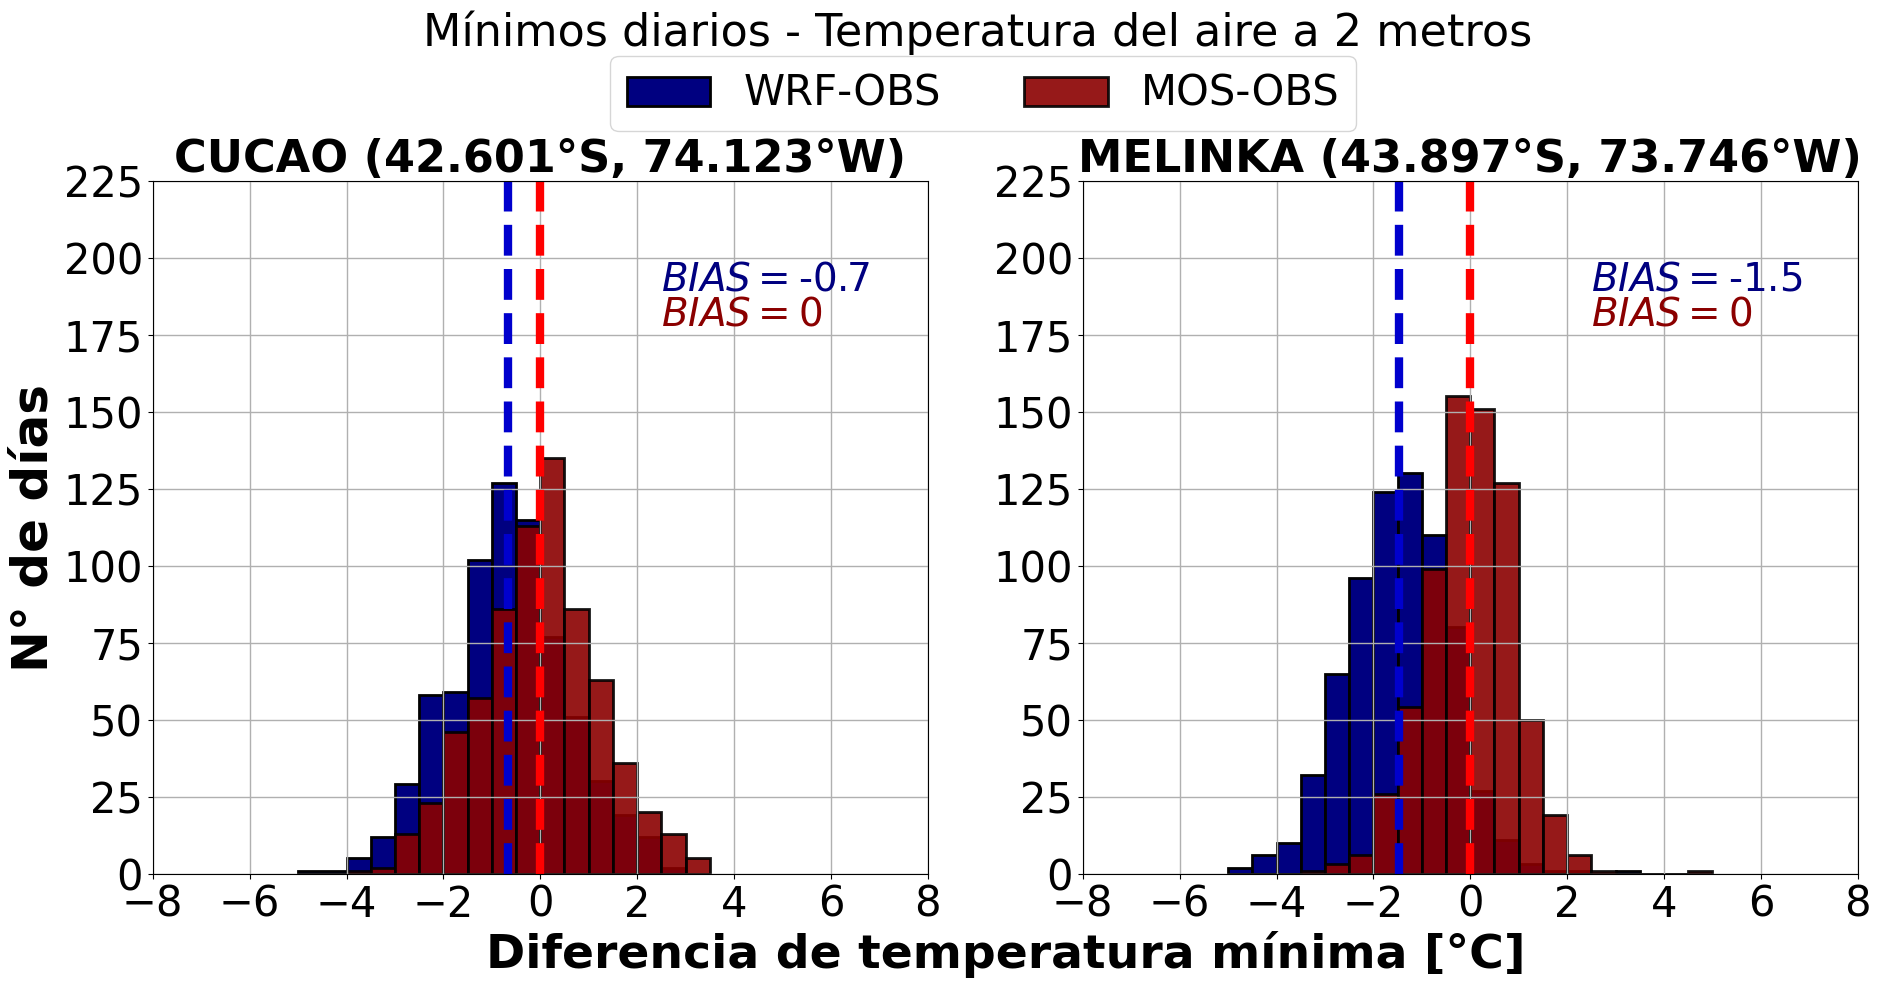

In [15]:
# HISTOGRAMA DE LAS DIFERENCIAS
intervalos = [-8, -6, -4, -2, 0, 2, 4, 6, 8] #indicamos los extremos de los intervalos
intervalos_y = [0, 25, 50, 75, 100, 125, 150, 175, 200,225] #indicamos los extremos de los intervalos

# ======================================================================================  
fig, ax = plt.subplots(1,2,figsize=(22,9),sharey=False)
plt.subplot(1,2,1) # DIFERENCIA TEMPERATURA MÁXIMA
fig.suptitle('Mínimos diarios - Temperatura del aire a 2 metros',x=0.5,y=1.07,fontsize=32)
plt.hist(WRF_CUCAO-OBS_CUCAO, bins=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5],color = "navy",edgecolor='k',alpha=1,linewidth=2,label='WRF-OBS')
plt.axvline((WRF_CUCAO-OBS_CUCAO).mean(), color='mediumblue', linestyle='dashed', linewidth=6)
plt.hist(MOS_CUCAO-OBS_CUCAO, bins=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5],color = "darkred",edgecolor='k',alpha=0.90,linewidth=2,label='MOS-OBS')
plt.axvline((MOS_CUCAO-OBS_CUCAO).mean(), color='red', linestyle='dashed', linewidth=6)
plt.ylabel('N° de días', fontsize=36, weight='bold')
plt.title('CUCAO (42.601°S, 74.123°W)',fontsize=32,weight='bold')
plt.ylim(0,225); plt.xlim(-8,8) ; plt.legend(bbox_to_anchor=(1.58, 1.21),fontsize=30,ncol=2)
plt.xticks(intervalos,fontsize=30);  plt.yticks(fontsize=30);  plt.grid(True,linewidth=1)
plt.yticks(intervalos_y); 
plt.text(2.5, 189.3, r'$BIAS=$-$0.7$',fontsize=28,color='navy')
plt.text(2.5, 178, r'$BIAS=0$',fontsize=28,color='darkred')

plt.subplot(1,2,2) # DIFERENCIA TEMPERATURA MÁXIMA
plt.hist(WRF_MELINKA-OBS_MELINKA, bins=[-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5],color = "navy",edgecolor='k',alpha=1,linewidth=2,label='WRF-OBS')
plt.axvline((WRF_MELINKA-OBS_MELINKA).mean(), color='mediumblue', linestyle='dashed', linewidth=6)
plt.hist(MOS_MELINKA-OBS_MELINKA, bins=[-5,-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5],color = "darkred",edgecolor='k',alpha=0.90,linewidth=2,label='MOS-OBS')
plt.axvline((MOS_MELINKA-OBS_MELINKA).mean(), color='red', linestyle='dashed', linewidth=6)
plt.title('MELINKA (43.897°S, 73.746°W)',fontsize=32,weight='bold')
plt.xlabel('Diferencia de temperatura mínima [°C]', fontsize=34, weight='bold', horizontalalignment='center', x=-0.1)
plt.ylim(0,225); plt.xlim(-8,8) ;
plt.xticks(intervalos,fontsize=30);  plt.yticks(fontsize=30);  plt.grid(True,linewidth=1)
plt.yticks(intervalos_y);
plt.text(2.5, 189.3, r'$BIAS=$-$1.5$',fontsize=28,color='navy')
plt.text(2.5, 178, r'$BIAS=0$',fontsize=28,color='darkred')
plt.savefig('hist_diferencias_Tmin.png')

In [16]:
## CUCAO WRF
print('BIAS (WRF): ', np.mean(WRF_CUCAO) - np.mean(OBS_CUCAO))
print('Correlación Pearson (WRF): ', np.corrcoef(WRF_CUCAO, OBS_CUCAO))
print('R-squared (WRF): ', (np.corrcoef(WRF_CUCAO, OBS_CUCAO))**2 )
print('RMSE (WRF): ', np.sqrt(mean_squared_error(WRF_CUCAO, OBS_CUCAO)))
print('COCIENTE STD (WRF): ', np.std(WRF_CUCAO) / np.std(OBS_CUCAO) )
print('==========================================================')
print('==========================================================')
## CUCAO MOS
print('BIAS (MOS): ', np.mean(MOS_CUCAO) - np.mean(OBS_CUCAO))
print('Correlación Pearson (MOS): ', np.corrcoef(MOS_CUCAO, OBS_CUCAO) )
print('R-squared (MOS): ', (np.corrcoef(MOS_CUCAO, OBS_CUCAO))**2 )
print('RMSE (MOS): ', np.sqrt(mean_squared_error(MOS_CUCAO, OBS_CUCAO)))
print('COCIENTE STD (MOS): ', np.std(MOS_CUCAO) / np.std(OBS_CUCAO) )

BIAS (WRF):  -0.6669781540486408
Correlación Pearson (WRF):  [[1.         0.92288804]
 [0.92288804 1.        ]]
R-squared (WRF):  [[1.         0.85172233]
 [0.85172233 1.        ]]
RMSE (WRF):  1.3932840102000825
COCIENTE STD (WRF):  0.8824190415350477
BIAS (MOS):  -3.552713678800501e-15
Correlación Pearson (MOS):  [[1.         0.92339071]
 [0.92339071 1.        ]]
R-squared (MOS):  [[1.         0.85265041]
 [0.85265041 1.        ]]
RMSE (MOS):  1.2127529660197633
COCIENTE STD (MOS):  0.9233907126334847


In [17]:
## MELINKA WRF
print('BIAS (WRF): ', np.mean(WRF_MELINKA) - np.mean(OBS_MELINKA))
print('Correlación Pearson (WRF): ', np.corrcoef(WRF_MELINKA, OBS_MELINKA))
print('R-squared (WRF): ', (np.corrcoef(WRF_MELINKA, OBS_MELINKA))**2 )
print('RMSE (WRF): ', np.sqrt(mean_squared_error(WRF_MELINKA, OBS_MELINKA)))
print('COCIENTE STD (WRF): ', np.std(WRF_MELINKA) / np.std(OBS_MELINKA) )
print('==========================================================')
print('==========================================================')
## MELINKA MOS
print('BIAS (MOS): ', np.mean(MOS_MELINKA) - np.mean(OBS_MELINKA))
print('Correlación Pearson (MOS): ', np.corrcoef(MOS_MELINKA, OBS_MELINKA) )
print('R-squared (MOS): ', (np.corrcoef(MOS_MELINKA, OBS_MELINKA))**2 )
print('RMSE (MOS): ', np.sqrt(mean_squared_error(MOS_MELINKA, OBS_MELINKA)))
print('COCIENTE STD (MOS): ', np.std(MOS_MELINKA) / np.std(OBS_MELINKA) )

BIAS (WRF):  -1.463227404520743
Correlación Pearson (WRF):  [[1.         0.93285557]
 [0.93285557 1.        ]]
R-squared (WRF):  [[1.         0.87021952]
 [0.87021952 1.        ]]
RMSE (WRF):  1.8013390980615156
COCIENTE STD (WRF):  1.074716399590048
BIAS (MOS):  -5.329070518200751e-15
Correlación Pearson (MOS):  [[1.         0.94400558]
 [0.94400558 1.        ]]
R-squared (MOS):  [[1.         0.89114653]
 [0.89114653 1.        ]]
RMSE (MOS):  0.8952740103441259
COCIENTE STD (MOS):  0.9440055770463969
